# Deep Learning Competition 2

Team 24: 109021115 吳嘉濬 113062594 陳力瑋 113024507 林俊甫 113062541 謝承彧

In [ ]:
import tensorflow as tf
import numpy as np
from abc import abstractmethod
import tensorflow.keras.layers as layers
from tensorflow.keras import Model, activations
from tensorflow.keras.layers import Layer
from datetime import datetime
from tqdm.autonotebook import tqdm
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess_input
import cv2
import matplotlib.pyplot as plt
import random

import warnings
warnings.filterwarnings("ignore")

C:\Users\Steven\AppData\Local\Temp\ipykernel_10596\3483416321.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Select GPU number 1
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Data preprocessing
The code in this part is to deal with the class imbalance problem in the given dataset
and apply some data augmentation on the image

In [ ]:
import numpy as np
from tqdm import tqdm
import cv2
import albumentations as A
import random

In [ ]:
def resize_with_bboxes(target_size, image, bboxes):
    resize = A.Compose([A.Resize(target_size[0], target_size[1], cv2.INTER_LINEAR)], bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.2))

    resized_img = resize(image=image.copy(), bboxes=bboxes.copy())

    return resized_img["image"].astype(np.uint8), resized_img["bboxes"]

In [ ]:
def mosaic_augmentation(images, bboxes, size=(448, 448)):
    assert len(images) == 4

    h, w = size

    images = [image.copy() for image in images]
    bboxes = [bb.copy() for bb in bboxes]

    # Select the middle points
    # Horizontal (width orientation)
    x = random.randint(int(h * 0.33), int(h * 0.67))
    # Vertical (height orientation)
    y = random.randint(int(w * 0.33), int(w * 0.67))

    # Resize images
    images[0], bboxes[0] = resize_with_bboxes((y, x), images[0], bboxes[0])
    images[1], bboxes[1] = resize_with_bboxes((y, w - x), images[1], bboxes[1])
    images[2], bboxes[2] = resize_with_bboxes((h - y, x), images[2], bboxes[2])
    images[3], bboxes[3] = resize_with_bboxes((h - y, w - x), images[3], bboxes[3])

    # Fill the result image
    result_image = np.zeros((*size, images[0].shape[-1]))

    result_image[:y, :x] = images[0]
    result_image[:y, x:] = images[1]
    result_image[y:, :x] = images[2]
    result_image[y:, x:] = images[3]

    # Compute the final bboxes
    result_bboxes = []

    for bbox in bboxes[0]:
        result_bboxes.append(bbox + np.array([0, 0, 0, 0, 0]))

    for bbox in bboxes[1]:
        result_bboxes.append(bbox + np.array([x, 0, x, 0, 0]))

    for bbox in bboxes[2]:
        result_bboxes.append(bbox + np.array([0, y, 0, y, 0]))

    for bbox in bboxes[3]:
        result_bboxes.append(bbox + np.array([x, y, x, y, 0]))

    return result_image.astype(np.uint8), np.array(result_bboxes)

In [ ]:
def mix_up_augmentation(images, bboxes, target_size=(448, 448), alpha=1.5):
    assert len(images) == 2

    lamb = random.betavariate(alpha, alpha)

    image1, image2 = [im.copy() for im in images]
    bboxes1, bboxes2 = [bb.copy() for bb in bboxes]

    image1, bboxes1 = resize_with_bboxes(target_size, image1, bboxes1)
    image2, bboxes2 = resize_with_bboxes(target_size, image2, bboxes2)

    result_image = image1 * lamb + image2 * (1 - lamb)
    result_bboxes = np.concatenate([bboxes1, bboxes2], axis=0)

    return result_image.astype(np.uint8), result_bboxes

In [ ]:
def random_transform(image, bboxes):
    transform = A.Compose([
        A.BBoxSafeRandomCrop(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.RandomScale(p=0.5),
        A.ShiftScaleRotate(rotate_limit=(-15, 15), p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.RGBShift(r_shift_limit=30, g_shift_limit=30, b_shift_limit=30, p=0.5),
        A.HueSaturationValue(p=0.5),
        A.Affine(p=0.5),
        A.Equalize(p=0.5),
    ], bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.2))

    image = image.copy()
    bboxes = bboxes.copy()

    transformed = transform(image=image, bboxes=bboxes)

    return transformed["image"].astype(np.uint8), transformed["bboxes"]

In [ ]:
object_details = {}

with open("./data/pascal_voc_training_data.txt", "r") as fr:
    for line in fr:
        line = line.strip().split()
        filename = line[0]

        object_details[filename] = []

        for idx in range(1, len(line), 5):
            object_details[filename].append(tuple([int(v) for v in line[idx: idx+5]]))

        if object_details[filename].__len__() == 0:
            print(filename)

object_details

{'000005.jpg': [(263, 211, 324, 339, 8),
  (165, 264, 253, 372, 8),
  (5, 244, 67, 374, 8),
  (241, 194, 295, 299, 8),
  (277, 186, 312, 220, 8)],
 '000007.jpg': [(141, 50, 500, 330, 6)],
 '000009.jpg': [(69, 172, 270, 330, 12),
  (150, 141, 229, 284, 14),
  (285, 201, 327, 331, 14),
  (258, 198, 297, 329, 14)],
 '000012.jpg': [(156, 97, 351, 270, 6)],
 '000016.jpg': [(92, 72, 305, 473, 1)],
 '000017.jpg': [(185, 62, 279, 199, 14), (90, 78, 403, 336, 12)],
 '000019.jpg': [(231, 88, 483, 256, 7), (11, 113, 266, 259, 7)],
 '000020.jpg': [(33, 148, 371, 416, 6)],
 '000021.jpg': [(1, 235, 182, 388, 11),
  (210, 36, 336, 482, 14),
  (46, 82, 170, 365, 14),
  (11, 181, 142, 419, 14)],
 '000023.jpg': [(9, 230, 245, 500, 1),
  (230, 220, 334, 500, 1),
  (2, 178, 90, 500, 1),
  (2, 1, 117, 369, 14),
  (3, 2, 243, 462, 14),
  (225, 1, 334, 486, 14)],
 '000024.jpg': [(196, 165, 489, 247, 18)],
 '000026.jpg': [(90, 125, 337, 212, 6)],
 '000030.jpg': [(36, 205, 180, 289, 1),
  (51, 160, 150, 292, 1

In [ ]:
classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle",
                 "bus", "car", "cat", "chair", "cow", "diningtable",
                 "dog", "horse", "motorbike", "person", "pottedplant",
                 "sheep", "sofa", "train","tvmonitor"]

In [ ]:
DATA_PATH = './data/pascal_voc_training_data.txt'

filename_to_class_ids = {}
class_to_filenames = [[] for _ in range(len(classes_name))]

training_data_file = open(DATA_PATH, "r")
for i, line in enumerate(training_data_file):
    line = line.strip()
    line = line.split(" ")
    filename = line[0]

    filename_to_class_ids[filename] = []

    class_ids = []
    for idx in range(5, min(len(line), 1000000), 5):
        class_id = int(float(line[idx]))
        class_ids.append(class_id)

    class_count_in_this_filename = [0 for _ in range(len(classes_name))]

    for class_id in class_ids:
        filename_to_class_ids[filename].append(class_id)
        class_count_in_this_filename[class_id] += 1

    class_count_in_this_filename = np.array(class_count_in_this_filename, dtype=np.float32)
    class_count_in_this_filename[class_count_in_this_filename == 0] = float("inf")

    # Put the filename to the minority class in current file
    minority_class = np.argmin(class_count_in_this_filename)
    class_to_filenames[minority_class].append(filename)

training_data_file.close()

In [ ]:
for name, filenames in zip(classes_name, class_to_filenames):
    print("{}: {}".format(name, len(filenames)))

aeroplane: 239
bicycle: 235
bird: 318
boat: 167
bottle: 190
bus: 172
car: 561
cat: 331
chair: 277
cow: 121
diningtable: 187
dog: 359
horse: 262
motorbike: 199
person: 665
pottedplant: 131
sheep: 79
sofa: 138
train: 222
tvmonitor: 121


In [ ]:
# Perform something like Class-aware sampling
sampled_class_counts = np.array([0 for _ in range(len(classes_name))])
class_sample_offset = [0 for _ in range(len(classes_name))]
sampled_filenames = []

target = 3000

while True:
    # Find the class with the smallest number of samples
    minority_class_idx = np.argmin(sampled_class_counts)
    majority_class_idx = np.argmax(sampled_class_counts)

    if minority_class_idx in [14]:
        continue

    # Stop condition
    if sampled_class_counts[minority_class_idx] >= target:
        break

    # if sampled_class_counts[majority_class_idx] >= upper_bound_target:
    #     break

    # Sample the filename from the minority class
    while True:
        sampled_filename = class_to_filenames[minority_class_idx][class_sample_offset[minority_class_idx]]
        class_sample_offset[minority_class_idx] = (class_sample_offset[minority_class_idx] + 1) % len(class_to_filenames[minority_class_idx])

        all_are_not_exceed = all([sampled_class_counts[class_id] < target for class_id in filename_to_class_ids[sampled_filename]])

        if all_are_not_exceed:
            break

    # Update the sampled class counts
    for class_id in filename_to_class_ids[sampled_filename]:
        sampled_class_counts[class_id] += 1

    # Update the sampled filenames
    sampled_filenames.append(sampled_filename)

# Print the sampled class counts
print("Sampled class counts")
for idx, (name, count) in enumerate(zip(classes_name, sampled_class_counts)):
    print("({:02d}) {:15s}: {:5d}".format(idx, name, count), end='\n' if idx % 5 == 4 else " ")
print()

# Check number of repeat filenames
repeat_file_counts = {}
for filename in sampled_filenames:
    if repeat_file_counts.get(filename, None) is not None:
        repeat_file_counts[filename] += 1
    else:
        repeat_file_counts[filename] = 1

k = 3
top_k_repeat = sorted(repeat_file_counts.items(), key=lambda item: item[1], reverse=True)[:k]

print("Repeat file counts")
for filename, count in top_k_repeat:
    print("{}: {}".format(filename, count))

print()

Sampled class counts
(00) aeroplane      :  3001 (01) bicycle        :  3000 (02) bird           :  3030 (03) boat           :  3001 (04) bottle         :  3002
(05) bus            :  3000 (06) car            :  3001 (07) cat            :  3000 (08) chair          :  3002 (09) cow            :  3009
(10) diningtable    :  3001 (11) dog            :  3000 (12) horse          :  3001 (13) motorbike      :  3000 (14) person         :  3000
(15) pottedplant    :  3000 (16) sheep          :  3014 (17) sofa           :  3000 (18) train          :  3000 (19) tvmonitor      :  3000

Repeat file counts
001834.jpg: 288
005521.jpg: 288
005803.jpg: 287



In [ ]:
# Count number of mix-up and mosaic
num_mix_up = sum([1 for item in sampled_filenames if isinstance(item, tuple) and item[0] == 'mix-up'])
num_mosaic = sum([1 for item in sampled_filenames if isinstance(item, tuple) and item[0] == 'mosaic'])

print("Number of mix-up: {}".format(num_mix_up))
print("Number of mosaic: {}".format(num_mosaic))
print("Number of normal: {}".format(len(sampled_filenames) - num_mix_up - num_mosaic))
print("Total number of samples: {}".format(len(sampled_filenames)))

Number of mix-up: 0
Number of mosaic: 0
Number of normal: 30804
Total number of samples: 30804


In [ ]:
repeat_count = {}

with open("./data/data_augmentation_pascal_voc_training_data_3000.txt", "w") as fw:
    def _add_new_image(image, bboxes, result_filename):
        if bboxes.shape[0] <= 0:
            print("Ignore file: {}".format(result_filename))
            return

        image, bboxes = random_transform(image, bboxes)
        image, bboxes = resize_with_bboxes((448, 448), image, bboxes)

        if bboxes.shape[0] <= 0:
            print("Ignore file: {}".format(result_filename))
            return

        cv2.imwrite('./data/VOC_Augmentation_train_3000/{}'.format(result_filename), image[:, :, ::-1])

        fw.write("{}".format(result_filename))

        for xmin, ymin, xmax, ymax, class_num in bboxes.astype(int).tolist():
            fw.write(" {} {} {} {} {}".format(xmin, ymin, xmax, ymax, class_num))

        fw.write("\n")

    for idx, filename in tqdm(enumerate(sampled_filenames), total=len(sampled_filenames)):
        if isinstance(filename, str):
            # Check if this image appears before
            if repeat_count.get(filename, None) is None:
                repeat_count[filename] = 0

            # Do nothing
            image = cv2.imread('./data/VOCdevkit_train/VOC2007/JPEGImages/{}'.format(filename))[:,:,::-1]
            bboxes = np.array(object_details[filename], dtype=np.float32)

            _add_new_image(image, bboxes, "rt_or_same_{}_{}".format(repeat_count[filename], filename))

            repeat_count[filename] = repeat_count[filename] + 1

        elif filename[0] == 'mosaic':
            mosaic_filanames = [filename[1][0], filename[1][1], filename[1][2], filename[1][3]]

            images = [cv2.imread('./data/VOCdevkit_train/VOC2007/JPEGImages/{}'.format(f))[:,:,::-1] for f in mosaic_filanames]
            bboxes = [np.array(object_details[f], dtype=np.float32) for f in mosaic_filanames]

            mosaic_image, mosaic_bboxes = mosaic_augmentation(images, bboxes)

            _add_new_image(mosaic_image, mosaic_bboxes, "mosaic_{}_{}.jpg".format('_'.join([f.split(".")[0] for f in mosaic_filanames]), idx))
        elif filename[0] == 'mix-up':
            filename1 = filename[1][0]
            filename2 = filename[1][1]

            image1 = cv2.imread('./data/VOCdevkit_train/VOC2007/JPEGImages/{}'.format(filename1))[:,:,::-1]
            image2 = cv2.imread('./data/VOCdevkit_train/VOC2007/JPEGImages/{}'.format(filename2))[:,:,::-1]
            bboxes1 = np.array(object_details[filename1], dtype=np.float32)
            bboxes2 = np.array(object_details[filename2], dtype=np.float32)

            mix_up_image, mix_up_bboxes = mix_up_augmentation([image1, image2], [bboxes1, bboxes2])

            clear_filename1 = filename1.split(".")[0]
            clear_filename2 = filename2.split(".")[0]

            _add_new_image(mix_up_image, mix_up_bboxes, "mix_up_{}_{}_{}.jpg".format(clear_filename1, clear_filename2, idx))
        else:
            raise Exception("Invalid filename: {}".format(filename))

 27%|██▋       | 8325/30804 [06:18<14:11, 26.40it/s]

Ignore file: rt_or_same_7_003754.jpg


 51%|█████     | 15738/30804 [11:20<11:18, 22.20it/s]

Ignore file: rt_or_same_4_003656.jpg


 61%|██████    | 18772/30804 [13:17<06:45, 29.65it/s]

Ignore file: rt_or_same_20_003754.jpg


 90%|████████▉ | 27703/30804 [19:08<01:56, 26.68it/s]

Ignore file: rt_or_same_10_007555.jpg


100%|██████████| 30804/30804 [21:02<00:00, 24.39it/s]


## Hyperparameters configuration

In [ ]:
# common params
IMAGE_SIZE = 448
BATCH_SIZE = 8
NUM_CLASSES = 20
MAX_OBJECTS_PER_IMAGE = 20

# dataset params
# DATA_PATH = './data/pascal_voc_training_data.txt'
DATA_PATH = './data/data_augmentation_pascal_voc_training_data_3000.txt'

# IMAGE_DIR = './data/VOCdevkit_train/VOC2007/JPEGImages/'
IMAGE_DIR = './data/VOC_Augmentation_train_3000/'

# model params
CELL_SIZE = 7
BOXES_PER_CELL = 2
OBJECT_SCALE = 1
NOOBJECT_SCALE = 0.5
CLASS_SCALE = 1
COORD_SCALE = 5

# training params
LEARNING_RATE = 1e-6
EPOCHS = 20

# Pretrain model config
PRETRAIN_MODEL = "resnet50"

pretrained_model_preprocess_input = None
if PRETRAIN_MODEL == "resnet50":
    pretrained_model_preprocess_input = resnet_preprocess_input
elif PRETRAIN_MODEL == "densenet121":
    pretrained_model_preprocess_input = densenet_preprocess_input
else:
    raise ValueError("Invalid pretrain model")

## Dataset

In [ ]:
classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle",
                 "bus", "car", "cat", "chair", "cow", "diningtable",
                 "dog", "horse", "motorbike", "person", "pottedplant",
                 "sheep", "sofa", "train","tvmonitor"]

In [ ]:
training_data_file = open(DATA_PATH, "r")
for i, line in enumerate(training_data_file):
    if i >5:
        break
    line = line.strip()
    print(line)

rt_or_same_0_000032.jpg 53 101 316 371 0 87 129 150 207 0 132 284 155 360 14
rt_or_same_0_000016.jpg 95 47 440 394 1
rt_or_same_0_000046.jpg 170 41 448 333 2
rt_or_same_0_000061.jpg 17 0 203 367 3 162 270 255 345 3
rt_or_same_0_000200.jpg 27 35 92 304 14 16 97 155 448 14 127 40 212 448 14 195 30 343 448 14 333 18 427 446 14 311 379 332 446 4 198 260 223 378 4
rt_or_same_0_000132.jpg 187 54 448 431 5


### Observe the data

In [ ]:
class_counts = [[name, 0] for name in classes_name]

training_data_file = open(DATA_PATH, "r")
for i, line in enumerate(training_data_file):
    line = line.strip()
    line = line.split(" ")

    for idx in range(5, len(line), 5):
        class_id = int(float(line[idx]))
        class_counts[class_id][1] += 1

for name, count in class_counts:
    print("{}: {}".format(name, count))

print()

# First method used to solve the class imbalance method: apply class weights on the loss
# class weights
total_count = sum([count for name, count in class_counts])
class_count = len(class_counts)
class_weights = [total_count / (class_count * count) for name, count in class_counts]

for name, weight in zip(classes_name, class_weights):
    print("{}: {}".format(name, weight))

aeroplane: 3051
bicycle: 3037
bird: 3075
boat: 3051
bottle: 3096
bus: 3079
car: 3128
cat: 3028
chair: 3147
cow: 3083
diningtable: 3121
dog: 3040
horse: 3039
motorbike: 3085
person: 3119
pottedplant: 3100
sheep: 3029
sofa: 3161
train: 3063
tvmonitor: 3114

aeroplane: 1.0102589314978696
bicycle: 1.0149160355614093
bird: 1.0023739837398373
boat: 1.0102589314978696
bottle: 0.9955749354005168
bus: 1.0010717765508281
car: 0.9853900255754475
cat: 1.0179326287978865
chair: 0.9794407372100413
cow: 0.9997729484268569
diningtable: 0.98760012816405
dog: 1.0139144736842105
horse: 1.0142481079302401
motorbike: 0.9991247974068072
person: 0.9882334081436358
pottedplant: 0.9942903225806452
sheep: 1.017596566523605
sofa: 0.9751028155646947
train: 1.0063010120796605
tvmonitor: 0.9898201669877971


In [ ]:
class_weights = tf.constant(class_weights)
class_weights

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([1.0102589 , 1.0149161 , 1.0023739 , 1.0102589 , 0.99557495,
       1.0010718 , 0.98539   , 1.0179327 , 0.97944075, 0.99977297,
       0.98760015, 1.0139145 , 1.0142481 , 0.9991248 , 0.9882334 ,
       0.99429035, 1.0175966 , 0.97510284, 1.006301  , 0.9898202 ],
      dtype=float32)>

In [ ]:
class DatasetGenerator:
    """
    Load pascalVOC 2007 dataset and creates an input pipeline.
    - Reshapes images into 448 x 448
    - converts [0 1] to [-1 1]
    - shuffles the input
    - builds batches
    """

    def __init__(self):
        self.image_names = []
        self.record_list = []
        self.object_num_list = []
        # filling the record_list
        input_file = open(DATA_PATH, 'r')

        for line in input_file:
            line = line.strip()
            ss = line.split(' ')
            self.image_names.append(ss[0])

            self.record_list.append([float(num) for num in ss[1:]])

            self.object_num_list.append(min(len(self.record_list[-1])//5,
                                            MAX_OBJECTS_PER_IMAGE))
            if len(self.record_list[-1]) < MAX_OBJECTS_PER_IMAGE*5:
                # if there are objects less than MAX_OBJECTS_PER_IMAGE, pad the list
                self.record_list[-1] = self.record_list[-1] +\
                [0., 0., 0., 0., 0.]*\
                (MAX_OBJECTS_PER_IMAGE-len(self.record_list[-1])//5)

            elif len(self.record_list[-1]) > MAX_OBJECTS_PER_IMAGE*5:
               # if there are objects more than MAX_OBJECTS_PER_IMAGE, crop the list
                self.record_list[-1] = self.record_list[-1][:MAX_OBJECTS_PER_IMAGE*5]

    def _data_preprocess(self, image_name, raw_labels, object_num):
        image_file = tf.io.read_file(IMAGE_DIR+image_name)
        image = tf.io.decode_jpeg(image_file, channels=3)

        h = tf.shape(image)[0]
        w = tf.shape(image)[1]

        width_ratio  = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32)
        height_ratio = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32)

        image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
        # image = (image/255) * 2 - 1
        image = pretrained_model_preprocess_input(image)

        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)

        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_ratio
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_ratio

        box_w = (xmax - xmin) * width_ratio
        box_h = (ymax - ymin) * height_ratio

        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis=1)

        return image, labels, tf.cast(object_num, tf.int32)

    def generate(self):
        dataset = tf.data.Dataset.from_tensor_slices((self.image_names,
                                                      np.array(self.record_list),
                                                      np.array(self.object_num_list)))
        dataset = dataset.shuffle(100000)
        dataset = dataset.map(self._data_preprocess,
                              num_parallel_calls = tf.data.experimental.AUTOTUNE)
        dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
        dataset = dataset.prefetch(buffer_size=200)
        # dataset = dataset.cache()
        # dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

        return dataset

## Model design

### Object Detection Model (YOLO)

In [ ]:
def conv_leaky_relu(inputs, filters, size, stride):
    x = layers.Conv2D(filters, size, stride, padding="same",)(inputs)
    x = layers.LeakyReLU(0.1)(x)
    return x

def residual_block(inputs, filters, size, stride, kernel_init: str='glorot_uniform'):
    x = tf.keras.layers.Conv2D(
        filters, size, stride, padding="same",
        kernel_initializer=kernel_init
    )(inputs)
    x = tf.keras.layers.LeakyReLU(0.1)(x)
    x = x + inputs
    return x

In [ ]:
# The YOLO model with the resnet50 backbone (or other model)
def yolo():
    yolo_input = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

    if PRETRAIN_MODEL == "densenet121":
        pretrained_model = tf.keras.applications.DenseNet121(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    elif PRETRAIN_MODEL == "resnet50":
        pretrained_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    else:
        raise ValueError("Invalid pretrain model")

    pretrained_model.trainable = False

    x = pretrained_model(yolo_input)

    x = conv_leaky_relu(x, 1024, 3, 1)
    x = tf.keras.layers.BatchNormalization()(x)
    x = conv_leaky_relu(x, 1024, 3, 2)
    x = tf.keras.layers.BatchNormalization()(x)

    x = conv_leaky_relu(x, 1024, 3, 1)
    x = tf.keras.layers.BatchNormalization()(x)
    x = conv_leaky_relu(x, 1024, 3, 1)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(4096, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)
    x = tf.keras.layers.LeakyReLU(0.1)(x)

    yolo_outputs = tf.keras.layers.Dense(CELL_SIZE * CELL_SIZE * (NUM_CLASSES + BOXES_PER_CELL * 5),
                            kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)

    return tf.keras.Model(inputs=yolo_input, outputs=yolo_outputs, name="YOLO")

# More model used...

YOLO = yolo()

In [ ]:
YOLO.summary()

Model: "YOLO"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 448, 448, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 14, 14, 2048)      23587712  
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 1024)      18875392  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 1024)      0         
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 1024)     4096      
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 1024)        9438208   
                                                              

### Models based on YOLO v7

In [ ]:
# Convolutional Block (CBS) Layer for CNN architectures.
class CBS(tf.keras.layers.Layer):
    def __init__(self, filters, size, stride, **kwargs):
        super().__init__(**kwargs)
        self.conv = layers.Conv2D(filters,
                                  size,
                                  stride,
                                  padding="same",
                                  kernel_initializer='he_normal',
                                  kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.batch_norm = layers.BatchNormalization()
        self.activation = layers.Activation('swish')

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.batch_norm(x)
        return self.activation(x)

# Convolutional Block (CBM) Layer for CNN architectures.
class CBM(tf.keras.layers.Layer):
    def __init__(self, filters, size, stride, **kwargs):
        super().__init__(**kwargs)
        self.conv = layers.Conv2D(filters,
                                  size,
                                  stride,
                                  padding="same",
                                  kernel_initializer='he_normal',
                                  kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.batch_norm = layers.BatchNormalization()
        self.activation = layers.Activation('sigmoid')

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.batch_norm(x)
        return self.activation(x)

# To aggregate and refine the features at different levels to enhance the network's ability to learn diverse features.
# Output shape == (H/2, W/2, filters/2)
class ELAN_W(tf.keras.layers.Layer):
    def __init__(self, filters):
        super().__init__()
        self.cbs1 = CBS(filters, 1, 1)
        self.cbs2 = CBS(filters, 1, 1)
        self.cbs3 = CBS(filters//2, 3, 1)
        self.cbs4 = CBS(filters//2, 3, 1)
        self.cbs5 = CBS(filters//2, 3, 1)
        self.cbs6 = CBS(filters//2, 3, 1)
        self.final_cbs = CBS(filters, 1, 1)
        self.concat = layers.Concatenate(axis=3)

    def call(self, inputs):
        # First branch
        x1 = self.cbs1(inputs)

        # Second branch
        x2 = self.cbs2(inputs)
        x3 = self.cbs3(x2)
        x4 = self.cbs4(x3)
        x5 = self.cbs5(x4)
        x6 = self.cbs6(x5)

        # Concatenation of the feature maps
        x = self.concat([x1, x2, x3, x4, x5, x6])
        return self.final_cbs(x)

# To enhance feature representations.
# Output shape == (H, W, filters)
class REP(tf.keras.layers.Layer):
    def __init__(self, filters):
        super().__init__()
        self.cbs1 = CBS(filters, 3, 1)
        self.cbs2 = CBS(filters, 1, 1)
        self.batch_norm = layers.BatchNormalization()
        self.activation = layers.Activation('swish')

    def call(self, inputs):
        x1 = self.cbs1(inputs)
        x2 = self.cbs2(inputs)
        x3 = self.batch_norm(inputs)
        return self.activation(x1+x2+x3)

# To perform downsampling s.t. the spatial dimensions of the feature maps can be reduced.
# Output shape == (H/2, W/2, filters)
class MP(tf.keras.layers.Layer):
    def __init__(self, filters):
        super().__init__()
        self.cbs1 = CBS(filters//2, 1, 1)
        self.cbs2 = CBS(filters//2, 1, 1)
        self.cbs3 = CBS(filters//2, 3, 2)
        self.pool = layers.MaxPooling2D(pool_size=2, strides=2, padding="same")
        self.concat = layers.Concatenate(axis=3)

    def call(self, inputs):
        x1 = self.cbs1(self.pool(inputs))
        x2 = self.cbs3(self.cbs2(inputs))
        return self.concat([x1, x2])

# To perform multi-scale feature extraction by combining spatial pyramid pooling and cross-stage partial connections
# followed by concatenation and convolution for enhanced feature representation.
# Output shape == (H, W, filters/2)
class SPPCSPC(tf.keras.layers.Layer):
    def __init__(self, filters):
        super().__init__()
        self.cbs1 = CBS(filters, 1, 1)
        self.cbs2 = CBS(filters, 1, 1)
        self.cbs3 = CBS(filters, 3, 1)
        self.cbs4 = CBS(filters, 1, 1)
        self.cbs5 = CBS(filters, 1, 1)
        self.cbs6 = CBS(filters, 3, 1)
        self.pool1 = layers.MaxPooling2D(pool_size=5, strides=1, padding="same")
        self.pool2 = layers.MaxPooling2D(pool_size=9, strides=1, padding="same")
        self.pool3 = layers.MaxPooling2D(pool_size=13, strides=1, padding="same")
        self.concat = layers.Concatenate(axis=3)
        self.final_cbs = CBS(filters, 1, 1)

    def call(self, inputs):
        # First branch
        x1 = self.cbs1(inputs)

        # Second branch
        x2 = self.cbs2(inputs)
        x3 = self.cbs3(x2)
        x4 = self.cbs4(x3)
        pool1 = self.pool1(x4)
        pool2 = self.pool2(x4)
        pool3 = self.pool3(x4)
        x5 = self.concat([x4, pool1, pool2, pool3])
        x6 = self.cbs5(x5)
        x7 = self.cbs6(x6)

        # Concatenation of the feature maps
        x = self.concat([x1, x7])
        return self.final_cbs(x)

#### Model based on YOLO v7 large

In [ ]:
yolo_input = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

pretrained_model = tf.keras.applications.DenseNet121(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
pretrained_model.trainable = False
x = pretrained_model(yolo_input)

x1 = SPPCSPC(512)(x)
x = layers.UpSampling2D(size=(2, 2), interpolation='nearest')(x)
x2 = ELAN_W(256)(x)
x = layers.UpSampling2D(size=(2, 2), interpolation='nearest')(x)
x = ELAN_W(128)(x)
x = MP(256)(x)
x = layers.Concatenate(axis=3)([x, x1, x2])

x = layers.Flatten()(x)
x = layers.Dense(4096, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)
x = layers.LeakyReLU(0.1)(x)

yolo_outputs = layers.Dense(CELL_SIZE * CELL_SIZE * (NUM_CLASSES + BOXES_PER_CELL * 5),
                        kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
YOLO = tf.keras.Model(inputs=yolo_input, outputs=yolo_outputs, name="YOLO")
YOLO.summary()

Model: "YOLO"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 448, 448, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ densenet121 (Functional)  │ (None, 14, 14, 1024)   │      7,037,504 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sppcspc (SPPCSPC)         │ (None, 14, 14, 512)    │      7,620,096 │ densenet121[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cbs_7 (CBS)               │ (None, 14, 14, 512)    │        264,704 │ sppcspc[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 28, 28, 512)    │              0 │ cbs_7[0][0]            │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ elan_w (ELAN_W)           │ (None, 28, 28, 256)    │      1,267,968 │ up_sampling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cbs_15 (CBS)              │ (None, 28, 28, 256)    │         66,816 │ elan_w[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_1           │ (None, 56, 56, 256)    │              0 │ cbs_15[0][0]           │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ elan_w_1 (ELAN_W)         │ (None, 56, 56, 128)    │        318,592 │ up_sampling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mp (MP)                   │ (None, 28, 28, 256)    │        182,144 │ elan_w_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4             │ (None, 28, 28, 512)    │              0 │ mp[0][0], elan_w[0][0] │
│ (Concatenate)             │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ elan_w_2 (ELAN_W)         │ (None, 28, 28, 256)    │      1,267,968 │ concatenate_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mp_1 (MP)                 │ (None, 14, 14, 512)    │        724,736 │ elan_w_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_7             │ (None, 14, 14, 1024)   │              0 │ mp_1[0][0],            │
│ (Concatenate)             │                        │                │ sppcspc[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ elan_w_3 (ELAN_W)         │ (None, 14, 14, 512)    │      5,059,072 │ concatenate_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rep (REP)                 │ (None, 14, 14, 512)    │      2,628,608 │ elan_w_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cbm (CBM)                 │ (None, 14, 14, 256)    │        132,352 │ rep[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)    

 Total params: 238,118,142 (908.35 MB)

 Trainable params: 231,054,526 (881.40 MB)

 Non-trainable params: 7,063,616 (26.95 MB)

#### Model based on YOLO v7 small

In [ ]:
yolo_input = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

pretrained_model = tf.keras.applications.DenseNet121(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
pretrained_model.trainable = False
x = pretrained_model(yolo_input)

x1 = SPPCSPC(256)(x)
x = layers.UpSampling2D(size=(2, 2), interpolation='nearest')(x1)
x = MP(256)(x)
x = layers.Concatenate(axis=3)([x, x1])
x = ELAN_W(128)(x)
x = REP(128)(x)


x = layers.Flatten()(x)
x = layers.Dense(512, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)
x = layers.LeakyReLU(0.1)(x)

yolo_outputs = layers.Dense(CELL_SIZE * CELL_SIZE * (NUM_CLASSES + BOXES_PER_CELL * 5),
                        kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
YOLO = tf.keras.Model(inputs=yolo_input, outputs=yolo_outputs, name="YOLO")
YOLO.summary()

Model: "YOLO"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 448, 448, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ densenet121 (Functional)  │ (None, 14, 14, 1024)   │      7,037,504 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sppcspc (SPPCSPC)         │ (None, 14, 14, 256)    │      2,171,648 │ densenet121[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 28, 28, 256)    │              0 │ sppcspc[0][0]          │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mp (MP)                   │ (None, 14, 14, 256)    │        214,912 │ up_sampling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 14, 14, 512)    │              0 │ mp[0][0],              │
│ (Concatenate)             │                        │                │ sppcspc[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ elan_w (ELAN_W)           │ (None, 14, 14, 128)    │        384,128 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rep (REP)                 │ (None, 14, 14, 128)    │        165,632 │ elan_w[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 25088)          │              0 │ rep[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 512)            │     12,845,568 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 512)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1470)           │        754,110 │ leaky_re_lu[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 23,573,502 (89.93 MB)

 Trainable params: 16,529,598 (63.06 MB)

 Non-trainable params: 7,043,904 (26.87 MB)

## Training phase

### Define loss

In [ ]:
# base boxes (for loss calculation)
base_boxes = np.zeros([CELL_SIZE, CELL_SIZE, 4])

# initializtion for each cell
for y in range(CELL_SIZE):
    for x in range(CELL_SIZE):
        base_boxes[y, x, :] = [IMAGE_SIZE / CELL_SIZE * x,
                               IMAGE_SIZE / CELL_SIZE * y, 0, 0]

base_boxes = np.resize(base_boxes, [CELL_SIZE, CELL_SIZE, 1, 4])
base_boxes = np.tile(base_boxes, [1, 1, BOXES_PER_CELL, 1])

In [ ]:
def iou(boxes1, boxes2):
    """calculate ious
    Args:
      boxes1: 4-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4]  ====> (x_center, y_center, w, h)
      boxes2: 1-D tensor [4] ===> (x_center, y_center, w, h)

    Return:
      iou: 3-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
      ====> iou score for each cell
    """

    #boxes1 : [4(xmin, ymin, xmax, ymax), cell_size, cell_size, boxes_per_cell]
    boxes1 = tf.stack([boxes1[:, :, :, 0] - boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] - boxes1[:, :, :, 3] / 2,
                      boxes1[:, :, :, 0] + boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] + boxes1[:, :, :, 3] / 2])

    #boxes1 : [cell_size, cell_size, boxes_per_cell, 4(xmin, ymin, xmax, ymax)]
    boxes1 = tf.transpose(boxes1, [1, 2, 3, 0])

    boxes2 =  tf.stack([boxes2[0] - boxes2[2] / 2, boxes2[1] - boxes2[3] / 2,
                      boxes2[0] + boxes2[2] / 2, boxes2[1] + boxes2[3] / 2])

    #calculate the left up point of boxes' overlap area
    lu = tf.maximum(boxes1[:, :, :, 0:2], boxes2[0:2])
    #calculate the right down point of boxes overlap area
    rd = tf.minimum(boxes1[:, :, :, 2:], boxes2[2:])

    #intersection
    intersection = rd - lu

    #the size of the intersection area
    inter_square = intersection[:, :, :, 0] * intersection[:, :, :, 1]

    mask = tf.cast(intersection[:, :, :, 0] > 0, tf.float32) * tf.cast(intersection[:, :, :, 1] > 0, tf.float32)

    #if intersection is negative, then the boxes don't overlap
    inter_square = mask * inter_square

    #calculate the boxs1 square and boxs2 square
    square1 = (boxes1[:, :, :, 2] - boxes1[:, :, :, 0]) * (boxes1[:, :, :, 3] - boxes1[:, :, :, 1])
    square2 = (boxes2[2] - boxes2[0]) * (boxes2[3] - boxes2[1])

    return inter_square/(square1 + square2 - inter_square + 1e-6)

def losses_calculation(predict, label):
    """
    calculate loss
    Args:
      predict: 3-D tensor [cell_size, cell_size, num_classes + 5 * boxes_per_cell]
      label : [1, 5]  (x_center, y_center, w, h, class)
    """
    label = tf.reshape(label, [-1])

    #Step A. calculate objects tensor [CELL_SIZE, CELL_SIZE]
    #turn pixel position into cell position (corner)
    min_x = (label[0] - label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_x = (label[0] + label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_y = (label[1] - label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_y = (label[1] + label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_x = tf.floor(min_x)
    min_y = tf.floor(min_y)

    max_x = tf.minimum(tf.math.ceil(max_x), CELL_SIZE)
    max_y = tf.minimum(tf.math.ceil(max_y), CELL_SIZE)

    #calculate mask of object with cells
    onset = tf.cast(tf.stack([max_y - min_y, max_x - min_x]), dtype=tf.int32)
    object_mask = tf.ones(onset, tf.float32)

    offset = tf.cast(tf.stack([min_y, CELL_SIZE - max_y, min_x, CELL_SIZE - max_x]), tf.int32)
    offset = tf.reshape(offset, (2, 2))
    object_mask = tf.pad(object_mask, offset, "CONSTANT")

    #Step B. calculate the coordination of object center and the corresponding mask
    #turn pixel position into cell position (center)
    center_x = label[0] / (IMAGE_SIZE / CELL_SIZE)
    center_x = tf.floor(center_x)

    center_y = label[1] / (IMAGE_SIZE / CELL_SIZE)
    center_y = tf.floor(center_y)

    response = tf.ones([1, 1], tf.float32)

    #calculate the coordination of object center with cells
    objects_center_coord = tf.cast(tf.stack([center_y, CELL_SIZE - center_y - 1,
                             center_x, CELL_SIZE - center_x - 1]),
                             tf.int32)
    objects_center_coord = tf.reshape(objects_center_coord, (2, 2))

    #make mask
    response = tf.pad(response, objects_center_coord, "CONSTANT")

    #Step C. calculate iou_predict_truth [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    predict_boxes = predict[:, :, NUM_CLASSES + BOXES_PER_CELL:]

    predict_boxes = tf.reshape(predict_boxes, [CELL_SIZE,
                                               CELL_SIZE,
                                               BOXES_PER_CELL, 4])
    #cell position to pixel position
    predict_boxes = predict_boxes * [IMAGE_SIZE / CELL_SIZE,
                                     IMAGE_SIZE / CELL_SIZE,
                                     IMAGE_SIZE, IMAGE_SIZE]

    #if there's no predict_box in that cell, then the base_boxes will be calcuated with label and got iou equals 0
    predict_boxes = base_boxes + predict_boxes

    iou_predict_truth = iou(predict_boxes, label[0:4])

    #calculate C tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    C = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    #calculate I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    I = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    max_I = tf.reduce_max(I, 2, keepdims=True)

    #replace large iou scores with response (object center) value
    I = tf.cast((I >= max_I), tf.float32) * tf.reshape(response, (CELL_SIZE, CELL_SIZE, 1))

    #calculate no_I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    no_I = tf.ones_like(I, dtype=tf.float32) - I

    p_C = predict[:, :, NUM_CLASSES:NUM_CLASSES + BOXES_PER_CELL]

    #calculate truth x, y, sqrt_w, sqrt_h 0-D
    x = label[0]
    y = label[1]

    sqrt_w = tf.sqrt(tf.abs(label[2]))
    sqrt_h = tf.sqrt(tf.abs(label[3]))

    #calculate predict p_x, p_y, p_sqrt_w, p_sqrt_h 3-D [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    p_x = predict_boxes[:, :, :, 0]
    p_y = predict_boxes[:, :, :, 1]

    p_sqrt_w = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 2])))
    p_sqrt_h = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 3])))

    #calculate ground truth p 1-D tensor [NUM_CLASSES]
    P = tf.one_hot(tf.cast(label[4], tf.int32), NUM_CLASSES, dtype=tf.float32)

    #calculate predicted p_P 3-D tensor [CELL_SIZE, CELL_SIZE, NUM_CLASSES]
    p_P = predict[:, :, 0:NUM_CLASSES]

    #class_loss
    class_loss = tf.nn.l2_loss(tf.reshape(object_mask, (CELL_SIZE, CELL_SIZE, 1)) * (p_P - P)) * CLASS_SCALE

    #object_loss
    object_loss = tf.nn.l2_loss(I * (p_C - C)) * OBJECT_SCALE

    #noobject_loss
    noobject_loss = tf.nn.l2_loss(no_I * (p_C)) * NOOBJECT_SCALE

    #coord_loss
    coord_loss = (tf.nn.l2_loss(I * (p_x - x)/(IMAGE_SIZE/CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_y - y)/(IMAGE_SIZE/CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_sqrt_w - sqrt_w))/IMAGE_SIZE +
                  tf.nn.l2_loss(I * (p_sqrt_h - sqrt_h))/IMAGE_SIZE) * COORD_SCALE

    return class_loss + object_loss + noobject_loss + coord_loss

In [ ]:
def yolo_loss(predicts, labels, objects_num):
    """
    Add Loss to all the trainable variables
    Args:
        predicts: 4-D tensor [batch_size, cell_size, cell_size, num_classes + 5 * boxes_per_cell]
        ===> (num_classes, boxes_per_cell, 4 * boxes_per_cell)
        labels  : 3-D tensor of [batch_size, max_objects, 5]
        objects_num: 1-D tensor [batch_size]
    """

    loss = 0.

    #you can parallel the code with tf.map_fn or tf.vectorized_map (big performance gain!)
    for i in tf.range(BATCH_SIZE):
        predict = predicts[i, :, :, :]
        label = labels[i, :, :]
        object_num = objects_num[i]

        for j in tf.range(object_num):
            results = losses_calculation(predict, label[j:j+1, :])
            loss = loss + results

    return loss/BATCH_SIZE

### Start training

In [ ]:
dataset = DatasetGenerator().generate()

In [ ]:
# Define the optimizer
# There are some optimizers we have tried:
# 1. Adam
# 2. SGD with polynomial-decay learning rate

# optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    1e-6,
    int(np.ceil(30800 / BATCH_SIZE)) * EPOCHS,
    1e-8,
    power=1
)
optimizer = tf.keras.optimizers.SGD(learning_rate_fn)

train_loss_metric = tf.keras.metrics.Mean(name='loss')

In [ ]:
# Reload some trained parameters
reload_from_ckpt = "./ckpts/new-YOLO-Resnet50-4/yolo-20"
EPOCHS_OFFSET = 0

if reload_from_ckpt is not None:
    ckpt = tf.train.Checkpoint(net=YOLO)
    ckpt.restore(reload_from_ckpt)

In [ ]:
ckpt = tf.train.Checkpoint(epoch=tf.Variable(0), net=YOLO)

manager = tf.train.CheckpointManager(ckpt, './ckpts/new-YOLO-Resnet50-5', max_to_keep=3,
                                     checkpoint_name='yolo')

In [ ]:
@tf.function
def train_step(image, labels, objects_num):
    with tf.GradientTape() as tape:
        outputs = YOLO(image)
        class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
        conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
        class_probs = tf.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
        confs = tf.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
        boxes = tf.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
        predicts = tf.concat([class_probs, confs, boxes], 3)

        loss = yolo_loss(predicts, labels, objects_num)

        if not tf.math.is_nan(loss):
            train_loss_metric(loss)

    if not tf.math.is_nan(loss):
        grads = tape.gradient(loss, YOLO.trainable_weights)
        optimizer.apply_gradients(zip(grads, YOLO.trainable_weights))
    else:
        tf.print("Ignore this update since there is NaN loss")

    return loss

In [ ]:
num_batchs = int(np.ceil(30800 / BATCH_SIZE))
progress_bar = tqdm(total=(EPOCHS - EPOCHS_OFFSET) * num_batchs, desc="Training")

print("{}, start training.".format(datetime.now()))
for i in range(EPOCHS - EPOCHS_OFFSET):
    train_loss_metric.reset_state()
    ckpt.epoch.assign_add(1)

    for idx, (image, labels, objects_num) in enumerate(dataset):
        current_loss = train_step(image, labels, objects_num)
        progress_bar.update(1)

        if idx % 10 == 0:
            print("[{:03d}/{:03d}] Loss: {}".format(idx+1, num_batchs, current_loss))

    print("{}, Epoch {}: loss {:.2f}".format(datetime.now(), i+1, train_loss_metric.result()))

    save_path = manager.save()
    print("Saved checkpoint for epoch {}: {}".format(int(ckpt.epoch), save_path))

Training:   0%|          | 0/77000 [00:00<?, ?it/s]

2024-11-16 22:13:23.008700, start training.
[001/3850] Loss: 5.931344032287598
[011/3850] Loss: 0.7808963060379028
[021/3850] Loss: 1.6244406700134277
[031/3850] Loss: 4.759424209594727
[041/3850] Loss: 3.2826414108276367
[051/3850] Loss: 0.06444066017866135
[061/3850] Loss: 1.5679199695587158
[071/3850] Loss: 0.13795775175094604
[081/3850] Loss: 0.4316452145576477
[091/3850] Loss: 3.5156028270721436
[101/3850] Loss: 0.03826174885034561
[111/3850] Loss: 0.16049496829509735
[121/3850] Loss: 0.7714758515357971
[131/3850] Loss: 1.3712332248687744
[141/3850] Loss: 1.5725512504577637
[151/3850] Loss: 0.6953717470169067
[161/3850] Loss: 0.7360080480575562
[171/3850] Loss: 2.1458897590637207
[181/3850] Loss: 2.287928342819214
[191/3850] Loss: 0.9905973076820374
[201/3850] Loss: 0.37471383810043335
[211/3850] Loss: 2.7333860397338867
[221/3850] Loss: 0.6168540120124817
[231/3850] Loss: 6.094637393951416
[241/3850] Loss: 0.23630301654338837
[251/3850] Loss: 0.3489779531955719
[261/3850] Loss: 1

## Testing phase

### Process YOLO's prediction

In [ ]:
def process_outputs(outputs, multiple_output: bool=False, conf_score_threshold: float=0.5):
    """
    Process YOLO outputs into bou
    """

    class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
    conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
    class_probs = np.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
    confs = np.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
    boxes = np.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
    predicts = np.concatenate([class_probs, confs, boxes], 3)

    p_classes = predicts[0, :, :, 0:20]
    C = predicts[0, :, :, 20:22]
    coordinate = predicts[0, :, :, 22:]

    p_classes = np.reshape(p_classes, (CELL_SIZE, CELL_SIZE, 1, 20))
    C = np.reshape(C, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 1))

    P = C * p_classes

    # Since the original model only process the output with the largest confidence score,
    # we modify the code so that it can process multiple outputs

    object_details = []

    conf_score_threshold = np.max(P) * conf_score_threshold

    coordinate = np.reshape(coordinate, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4))

    for obj_idx, index in enumerate(np.argsort(P, axis=None)[::-1].tolist()):
        index = np.unravel_index(index, P.shape)

        class_num = index[3]

        conf_score = P[index[0], index[1], index[2], class_num]

        # Output one object even if the confidence score is below the threshold
        if conf_score < conf_score_threshold and multiple_output and obj_idx > 0:
            break

        max_coordinate = coordinate[index[0], index[1], index[2], :]

        xcenter = max_coordinate[0]
        ycenter = max_coordinate[1]
        w = max_coordinate[2]
        h = max_coordinate[3]

        xcenter = (index[1] + xcenter) * (IMAGE_SIZE/float(CELL_SIZE))
        ycenter = (index[0] + ycenter) * (IMAGE_SIZE/float(CELL_SIZE))

        w = w * IMAGE_SIZE
        h = h * IMAGE_SIZE

        xmin = xcenter - w/2.0
        ymin = ycenter - h/2.0

        xmax = xmin + w
        ymax = ymin + h

        object_details.append((xmin, ymin, xmax, ymax, class_num, conf_score))

        # If only output single object, then break
        if not multiple_output:
            break

    return object_details

### Build Test Dataset Iterator

In [ ]:
test_img_files = open('./data/pascal_voc_testing_data.txt')
test_img_dir = './data/VOCdevkit_test/VOC2007/JPEGImages/'
test_images = []

for line in test_img_files:
    line = line.strip()
    ss = line.split(' ')
    test_images.append(ss[0])

test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

def load_img_data(image_name):
    image_file = tf.io.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    # image = (image/255) * 2 - 1

    # Remember to replace this line to the corresponding preprocess_input function!!!
    image = pretrained_model_preprocess_input(image)

    return image_name, image, h, w

test_dataset = test_dataset.map(load_img_data, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32)

In [ ]:
ckpt = tf.train.Checkpoint(net=YOLO)
ckpt.restore('./ckpts/new-YOLO-Resnet50-4/yolo-20')

In [ ]:
@tf.function
def prediction_step(img):
    return YOLO(img, training=False)

### Make prediction and output to txt file

In [ ]:
output_file = open('./test_prediction.txt', 'w')

progress_bar = tqdm(total=int(np.ceil(4901 / 32).item()), desc="Prediction")

for img_name, test_img, img_h, img_w in test_dataset:
    batch_num = img_name.shape[0]
    for i in range(batch_num):
        # xmin, ymin, xmax, ymax, class_num, conf = process_outputs(prediction_step(test_img[i:i+1]))
        # xmin, ymin, xmax, ymax = xmin*(img_w[i:i+1]/IMAGE_SIZE), ymin*(img_h[i:i+1]/IMAGE_SIZE), xmax*(img_w[i:i+1]/IMAGE_SIZE), ymax*(img_h[i:i+1]/IMAGE_SIZE)

        #img filename, xmin, ymin, xmax, ymax, class, confidence
        # output_file.write(img_name[i:i+1].numpy()[0].decode('ascii')+" %d %d %d %d %d %f\n" %(xmin, ymin, xmax, ymax, class_num, conf))

        outputs = process_outputs(prediction_step(test_img[i:i+1]), multiple_output=True, conf_score_threshold=0.05)

        # Write the image filename first
        output_file.write(img_name[i:i+1].numpy()[0].decode('ascii'))

        for xmin, ymin, xmax, ymax, class_num, conf in outputs:
            xmin, ymin, xmax, ymax = xmin*(img_w[i:i+1]/IMAGE_SIZE), ymin*(img_h[i:i+1]/IMAGE_SIZE), xmax*(img_w[i:i+1]/IMAGE_SIZE), ymax*(img_h[i:i+1]/IMAGE_SIZE)
            output_file.write(" %d %d %d %d %d %f" %(xmin, ymin, xmax, ymax, class_num, conf))

        output_file.write("\n")

    progress_bar.update(1)

progress_bar.close()
output_file.close()

Prediction:   0%|          | 0/154 [00:00<?, ?it/s]

### Run evaluation

In [ ]:
import sys
sys.path.insert(0, './evaluate')

In [ ]:
import evaluate
#evaluate.evaluate("input prediction file name", "desire output csv file name")
evaluate.evaluate('./test_prediction.txt', './output_file.csv')

End Evalutation


In [ ]:
import pandas as pd

cap = pd.read_csv('./output_file.csv')['packedCAP']
print('score: {:f}'.format(sum((1. - cap) ** 2) / len(cap)))

score: 0.406089


### Visualization

In [ ]:
ckpt = tf.train.Checkpoint(net=YOLO)
ckpt.restore("./ckpts/new-YOLO-Resnet50-2/yolo-20")

person: 0.11866004765033722
person: 0.10128121823072433
horse: 0.09380275011062622
horse: 0.09100267291069031
horse: 0.08027010411024094
person: 0.05064887925982475
person: 0.045000724494457245
horse: 0.04438311606645584
horse: 0.044021934270858765
person: 0.0412508063018322
horse: 0.03985923156142235
horse: 0.0384901762008667
horse: 0.034000005573034286
person: 0.028872312977910042
horse: 0.02802070789039135


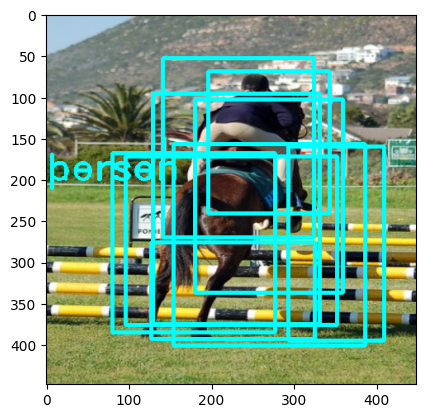

In [ ]:
np_img = cv2.imread('./data/VOCdevkit_test/VOC2007/JPEGImages/000010.jpg')
resized_img = cv2.resize(np_img, (IMAGE_SIZE, IMAGE_SIZE))
np_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
resized_img = np_img
np_img = np_img.astype(np.float32)
# np_img = np_img / 255.0 * 2 - 1

# Remember to replace this line to the corresponding preprocess_input function!!!
np_img = pretrained_model_preprocess_input(np_img)
np_img = np.reshape(np_img, (1, IMAGE_SIZE, IMAGE_SIZE, 3))

y_pred = YOLO(np_img, training=False)

for idx, (xmin, ymin, xmax, ymax, class_num, conf) in enumerate(process_outputs(y_pred, multiple_output=True, conf_score_threshold=0.20)):
    # if idx not in [0]:
    #     continue

    class_name = classes_name[class_num]
    cv2.rectangle(resized_img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 255), 3)
    cv2.putText(resized_img, class_name, (0, 200), 2, 1.5, (0, 255, 255), 2)
    print("{}: {}".format(class_name, conf))

plt.imshow(resized_img)
plt.show()

## Report

#### Data augmentation
* The provided dataset has the serious class imbalance problem. We design a method to generate new dataset with all class has the equal number (~3000) of images, based on CAS (class-Aware Sampling) to sample images from the original dataset.
* We found that some images appear in the new dataset for more than 250 times! Although it is a little weird, but since we will do the data augmentation later, so it might not matter.
* For data augmentation, we applied lots of method: cropping, horizontal flipping, rotation, color adjustment, brightness and contrast adjustment, affine transformation and equalize. All of them are done using the package `albumentations`.

#### Model selection and Training details
* YOLO + Resnet50
    * We use the YOLO as our model. For the backbone, we use the resnet50, pretrained on the Imagenet, as our backbone.
    * Optimizer: Adam / SGD + polynomial-decay learning rate
    * The backbone is frozen.
    * Training details: Since training process usually takes long time, we didn't train the model at the same time. In summary, we trained the model (resnet50 backbone) for 40 epochs using the learning rate 1e-5 and Adam. After 40th epoch, we trained the model for 20 epochs with learning rate 1e-6 and Adam. Finally, we trained the model again, after 60th epoch, with SGD learning rate linearly decay from 1e-6 to 1e-8.
    * Evaluation: we modified the function `process_outputs` so that it supports multiple output, with one more hyperparameter: confidence score threshold.
    * Since the confidence scores across images have large variation, the confidence score threshold is defined as the "relative" confidence score, which is the ratio between the confidence score and largest confidence score.
    * After experiments, we found that when threshold is 0.05, the model has the best score, which is 0.406089.
* YOLO + Desnet121
    * We have tried the YOLO with Desnet121.
    * The model has trained for 40 epochs. When all configurations are the same (same dataset, threshold = 1 since we haven't modified `process_outputs` at that time), the score is 0.508443. Compare the one with resnet50, whose score is 0.491833 when threshold is 1 with the same configurations, the one with resnet50 is better. So we determined to use the resnet50 instead.
* YOLO + Resnet101
    * We also tried resnet 101 as a backbone.
    * The backbone is frozen.
    * The model has trained for 80 epochs. Use SGD as optimizer, and learning rate linearly decay from 1e-3 to 1e-4.
    * The score is 0.463287 (threshold = 0.05).
    * The initial training results are not bad, but there is still a gap with resnet50, maybe we need to train more epochs or tuning hyperparameters.
* Model based on YOLO v7 large + Desnet121
    * We replaced the backbone of YOLO v7 by Desnet121.
    * The backbone is frozen.
    * The output layer is the same as the above
    * We use the same yolo loss here.
    * The model was trained for 90 epochs, using AdamW as the optimizer for the first 40 epochs with learning rate 1e-5 and switching to SGD with learning rate 1e-5 for the remaining 50 epochs.
    * The score is 0.517658.
    * This model had 231,054,526 trainable weights. It was hard to trained since our data were too small. So we tried the following one.

* Model based on YOLO v7 small + Desnet121
    * We replaced the backbone of YOLO v7 by Desnet121.
    * The backbone is frozen.
    * We reduced the dimensions of the fully connected layer and simplified the model architecture.
    * We use the same yolo loss here.
    * The model was trained for 52 epochs, using SGD with learning rate 1e-5 as the optimizer.
    * The score is 0.475241.
    * This model contains only 16,529,598 trainable parameters, making it ten times smaller than the larger model mentioned earlier. While its performance is not good enough, it is the smallest among all the models discussed.

#### Difficulties and solutions
* We found the important of class balance in the dataset. At the beginning, we didn't put lots of effort on dealing with it. But it turns out the performance of model is not good as expected, even if we tried some other different data augmentation, like mix-up and mosaic. The training became easier after dealing with the class imbalance problem.
* At the beginning, we tried to apply some class weights on the loss function to deal with the class imbalance problem, but the performance was not good enough as well. We learnt that although a method makes sense, it might not work in every case, especially in the field of deep learning. The best practice is to tried lots of different method and find out the one with the best performance.

#### Reference
* Some data augmentation methods are inspired from these works:
    * [Class Imbalance in Object Detection: An Experimental Diagnosis and Study of Mitigation Strategies](https://arxiv.org/html/2403.07113v1)
    * [Learning Data Augmentation Strategies for Object Detection](https://arxiv.org/pdf/1906.11172)